In [ ]:
from setuptools import distutils
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from scipy import signal
from sklearn.model_selection import train_test_split

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.17.0


In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
# Read the IQ samples from the file
def load_iq_samples(file, dataset_name='data', labelset_name='label', dev_range=range(10), pkt_range=slice(0, 10)):
  f = h5py.File(file, 'r')
  label = f[labelset_name][:]
  label = label.astype(int)
  label = np.transpose(label)
  label = label - 1

  label_start = int(label[0]) + 1
  label_end = int(label[-1]) + 1
  num_dev = label_end - label_start + 1
  num_pkt = len(label)
  num_pkt_per_dev = int(num_pkt / num_dev)

  print('Dataset information: Dev ' + str(label_start) + ' to Dev ' +
            str(label_end) + ', ' + str(num_pkt_per_dev) + ' packets per device.')

  sample_index_list = []

  for dev_idx in dev_range:
      sample_index_dev = np.where(label == dev_idx)[0][pkt_range].tolist()
      sample_index_list.extend(sample_index_dev)

  data = f[dataset_name][sample_index_list]
  data = _convert_to_complex(data)

  label = label[sample_index_list]

  f.close()
  return data, label

def _convert_to_complex(data):
  num_row = data.shape[0]
  num_col = data.shape[1]
  data_complex = np.zeros([num_row, round(num_col / 2)], dtype=complex)

  data_complex = data[:, :round(num_col / 2)] + 1j * data[:, round(num_col / 2):]
  return data_complex


In [ ]:
class ChannelIndSpectrogram():
    """
    Source: https://github.com/gxhen/LoRa_RFFI/blob/main/Openset_RFFI_TIFS/dataset_preparation.py

    Public code for the paper:
    --------------------------
    G. Shen, J. Zhang, A. Marshall, and J. Cavallaro.
    “Towards Scalable and Channel-Robust Radio Frequency Fingerprint Identification for LoRa,”
    IEEE Trans. Inf. Forensics Security, 2022.
    --------------------------
    """
    def __init__(self,):
        pass

    def _normalization(self,data):
        ''' Normalize the signal.'''
        # s_norm = np.zeros(data.shape, dtype=complex)

        # for i in range(data.shape[0]):

        #     sig_amplitude = np.abs(data[i])
        #     rms = np.sqrt(np.mean(sig_amplitude**2))
        #     s_norm[i] = data[i]/rms

        # return s_norm
        return data / np.sqrt(np.mean(np.abs(data)**2))

    def _spec_crop(self, x):
        '''Crop the generated channel independent spectrogram.'''
        num_row = x.shape[0]
        x_cropped = x[round(num_row*0.3):round(num_row*0.7)]

        return x_cropped


    def _gen_single_channel_ind_spectrogram(self, sig, win_len=256, overlap=128):
        '''
        _gen_single_channel_ind_spectrogram converts the IQ samples to a channel
        independent spectrogram according to set window and overlap length.

        INPUT:
            SIG is the complex IQ samples.

            WIN_LEN is the window length used in STFT.

            OVERLAP is the overlap length used in STFT.

        RETURN:

            CHAN_IND_SPEC_AMP is the genereated channel independent spectrogram.
        '''
        # Short-time Fourier transform (STFT).
        f, t, spec = signal.stft(sig,
                                window='boxcar',
                                nperseg= win_len,
                                noverlap= overlap,
                                nfft= win_len,
                                return_onesided=False,
                                padded = False,
                                boundary = None)

        # FFT shift to adjust the central frequency.
        spec = np.fft.fftshift(spec, axes=0)

        # Generate channel independent spectrogram.
        chan_ind_spec = spec[:,1:]/spec[:,:-1]

        # Take the logarithm of the magnitude.
        chan_ind_spec_amp = np.log10(np.abs(chan_ind_spec)**2)

        return chan_ind_spec_amp


    def channel_ind_spectrogram(self, data):
        '''
        channel_ind_spectrogram converts IQ samples to channel independent
        spectrograms.

        INPUT:
            DATA is the IQ samples.

        RETURN:
            DATA_CHANNEL_IND_SPEC is channel independent spectrograms.
        '''

        # Normalize the IQ samples.
        data = self._normalization(data)

        # Calculate the size of channel independent spectrograms.
        num_sample = data.shape[0]
        num_row = int(256*0.4)
        num_column = int(np.floor((data.shape[1]-256)/128 + 1) - 1)
        data_channel_ind_spec = np.zeros([num_sample, num_row, num_column, 1])

        # Convert each packet (IQ samples) to a channel independent spectrogram.
        for i in range(num_sample):

            chan_ind_spec_amp = self._gen_single_channel_ind_spectrogram(data[i])
            chan_ind_spec_amp = self._spec_crop(chan_ind_spec_amp)
            data_channel_ind_spec[i,:,:,0] = chan_ind_spec_amp

        return data_channel_ind_spec

Dataset information: Dev 1 to Dev 30, 500 packets per device.


<ipython-input-3-11967d598270>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_start = int(label[0]) + 1
<ipython-input-3-11967d598270>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_end = int(label[-1]) + 1


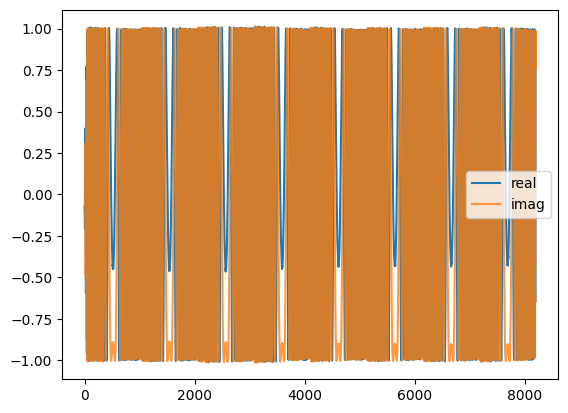

In [ ]:
# Data from the LoRaRffi dataset is already CFO compensated
file = '/content/dataset_training_no_aug.h5'

data_, label_ = load_iq_samples(file, dev_range=np.arange(0,10, dtype=int), pkt_range=np.arange(0,100, dtype=int))

data = data_[0, :]

data = data / np.sqrt(np.mean(np.abs(data)**2))

# Plot the data
plt.plot(data.real, label='real')
plt.plot(data.imag, label='imag', alpha=.8)
plt.legend()
plt.show()

In [ ]:
ChannelIndSpectrogramObj = ChannelIndSpectrogram()

data_channel_ind_spec = ChannelIndSpectrogramObj.channel_ind_spectrogram(data_)

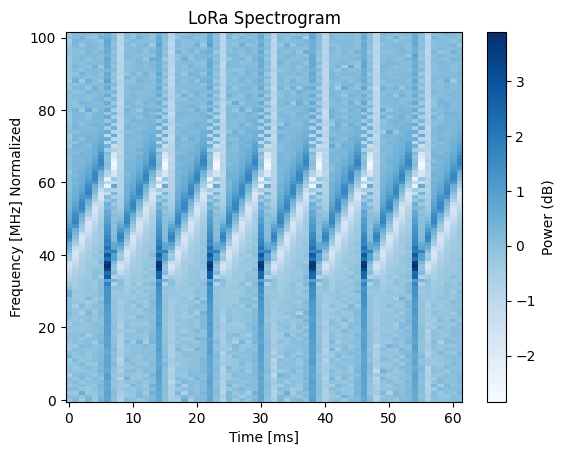

In [ ]:
im = plt.imshow(data_channel_ind_spec[0, :, :, 0], aspect='auto', origin='lower', cmap='Blues')
plt.colorbar(im).set_label('Power (dB)')
plt.xlabel('Time [ms]')
plt.ylabel('Frequency [MHz] Normalized')
plt.title('LoRa Spectrogram')
plt.show()

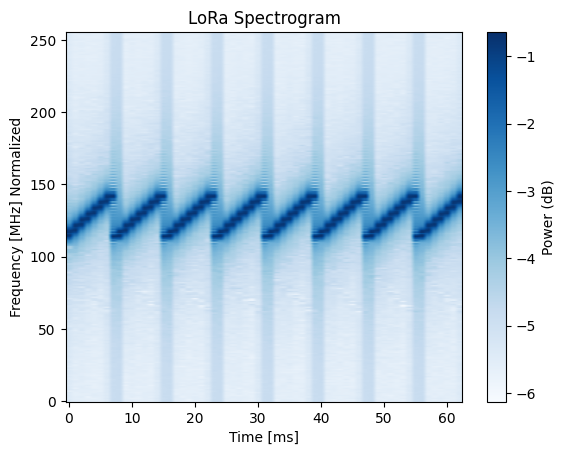

In [ ]:
# Plot the normal spectrogram
data = data_[0]
data = data / np.sqrt(np.mean(np.abs(data)**2))
f, t, spec = signal.stft(data, window='boxcar', nperseg=256, noverlap=128, nfft=256, return_onesided=False, padded=False, boundary=None)
spec = np.fft.fftshift(spec, axes=0)
spec = np.log10(np.abs(spec)**2)

im = plt.imshow(spec, aspect='auto', origin='lower', cmap='Blues')
plt.colorbar(im).set_label('Power (dB)')
plt.xlabel('Time [ms]')
plt.ylabel('Frequency [MHz] Normalized')
plt.title('LoRa Spectrogram')
plt.show()

In [ ]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Lambda, ReLU, Add, Dense, Conv2D, Flatten, AveragePooling2D


# In[]
def resblock(x, kernelsize, filters, first_layer = False):

    if first_layer:
        fx = Conv2D(filters, kernelsize, padding='same')(x)
        fx = ReLU()(fx)
        fx = Conv2D(filters, kernelsize, padding='same')(fx)

        x = Conv2D(filters, 1, padding='same')(x)

        out = Add()([x,fx])
        out = ReLU()(out)
    else:
        fx = Conv2D(filters, kernelsize, padding='same')(x)
        fx = ReLU()(fx)
        fx = Conv2D(filters, kernelsize, padding='same')(fx)


        out = Add()([x,fx])
        out = ReLU()(out)

    return out

def identity_loss(y_true, y_pred):
    return tf.math.reduce_mean(y_pred)


class TripletNet():
    def __init__(self):
        pass

    def create_triplet_net(self, embedding_net, alpha):

#        embedding_net = encoder()
        self.alpha = alpha

        input_1 = Input([self.datashape[1],self.datashape[2],self.datashape[3]])
        input_2 = Input([self.datashape[1],self.datashape[2],self.datashape[3]])
        input_3 = Input([self.datashape[1],self.datashape[2],self.datashape[3]])

        A = embedding_net(input_1)
        P = embedding_net(input_2)
        N = embedding_net(input_3)

        loss = Lambda(self.triplet_loss, output_shape=(1,), name='loss')([A, P, N])
        model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
        return model

    def triplet_loss(self,x):
    # Triplet Loss function.
        anchor,positive,negative = x
#        K.l2_normalize
    # distance between the anchor and the positive
        pos_dist = tf.reduce_sum(tf.math.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
        neg_dist = tf.reduce_sum(tf.math.square(anchor-negative),axis=1)

        basic_loss = pos_dist-neg_dist + self.alpha
        loss = tf.math.maximum(basic_loss,0.0)
        return loss

    def feature_extractor(self, datashape):

        self.datashape = datashape

        inputs = Input(shape=([self.datashape[1],self.datashape[2],self.datashape[3]]))

        x = Conv2D(32, 7, strides = 2, activation='relu', padding='same')(inputs)

        x = resblock(x, 3, 32)
        x = resblock(x, 3, 32)

        x = resblock(x, 3, 64, first_layer = True)
        x = resblock(x, 3, 64)

        x = AveragePooling2D(pool_size=2)(x)

        x = Flatten()(x)

        x = Dense(512)(x)

        outputs = Lambda(lambda  x: tf.math.l2_normalize(x,axis=1), output_shape=(512,))(x)

        model = Model(inputs=inputs, outputs=outputs)
        return model


    def get_triplet(self):
        """Choose a triplet (anchor, positive, negative) of images
        such that anchor and positive have the same label and
        anchor and negative have different labels."""


        n = a = self.dev_range[np.random.randint(len(self.dev_range))]

        while n == a:
            # keep searching randomly!
            n = self.dev_range[np.random.randint(len(self.dev_range))]
        a, p = self.call_sample(a), self.call_sample(a)
        n = self.call_sample(n)

        return a, p, n


    def call_sample(self,label_name):
        """Choose an image from our training or test data with the
        given label."""
        num_sample = len(self.label)
        idx = np.random.randint(num_sample)
        while self.label[idx] != label_name:
            # keep searching randomly!
            idx = np.random.randint(num_sample)
        return self.data[idx]


    def create_generator(self, batchsize, dev_range, data, label):
        """Generate a triplets generator for training."""
        self.data = data
        self.label = label
        self.dev_range = dev_range

        while True:
            list_a = []
            list_p = []
            list_n = []

            for i in range(batchsize):
                a, p, n = self.get_triplet()
                list_a.append(a)
                list_p.append(p)
                list_n.append(n)

            A = np.array(list_a, dtype='float32')
            P = np.array(list_p, dtype='float32')
            N = np.array(list_n, dtype='float32')

           # a "dummy" label which will come in to our identity loss
           # function below as y_true. We'll ignore it.
            label = np.ones(batchsize)
            yield (A, P, N), label

In [ ]:
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop

def train_feature_extractor(
        file_path = './dataset/Train/dataset_training_aug.h5',
        dev_range = np.arange(0,10, dtype = int),
        pkt_range = np.arange(0,200, dtype = int),
        snr_range = np.arange(20,80)
                            ):
    '''
    train_feature_extractor trains an RFF extractor using triplet loss.

    INPUT:
        FILE_PATH is the path of training dataset.

        DEV_RANGE is the label range of LoRa devices to train the RFF extractor.

        PKT_RANGE is the range of packets from each LoRa device to train the RFF extractor.

        SNR_RANGE is the SNR range used in data augmentation.

    RETURN:
        FEATURE_EXTRACTOR is the RFF extractor which can extract features from
        channel-independent spectrograms.
    '''

    file = '/content/dataset_training_no_aug.h5'

    data, label = load_iq_samples(file, dev_range=np.arange(0,10, dtype=int), pkt_range=np.arange(0,100, dtype=int))

    ChannelIndSpectrogramObj = ChannelIndSpectrogram()

    # Convert time-domain IQ samples to channel-independent spectrograms.
    data = ChannelIndSpectrogramObj.channel_ind_spectrogram(data)

    # Specify hyper-parameters during training.
    margin = 0.1
    batch_size = 32
    patience = 20

    TripletNetObj = TripletNet()

    # Create an RFF extractor.
    feature_extractor = TripletNetObj.feature_extractor(data.shape)

    # Create the Triplet net using the RFF extractor.
    triplet_net = TripletNetObj.create_triplet_net(feature_extractor, margin)

    # Create callbacks during training. The training stops when validation loss
    # does not decrease for 30 epochs.
    early_stop = EarlyStopping('val_loss',
                               min_delta = 0,
                               patience =
                               patience)

    reduce_lr = ReduceLROnPlateau('val_loss',
                                  min_delta = 0,
                                  factor = 0.2,
                                  patience = 10,
                                  verbose=1)
    callbacks = [early_stop, reduce_lr]

    # Split the dasetset into validation and training sets.
    data_train, data_valid, label_train, label_valid = train_test_split(data,
                                                                        label,
                                                                        test_size=0.1,
                                                                        shuffle= True)
    del data, label

    # Create the trainining generator.
    train_generator = TripletNetObj.create_generator(batch_size,
                                                     dev_range,
                                                     data_train,
                                                     label_train)
    # Create the validation generator.
    valid_generator = TripletNetObj.create_generator(batch_size,
                                                     dev_range,
                                                     data_valid,
                                                     label_valid)


    # Use the RMSprop optimizer for training.
    opt = RMSprop(learning_rate=1e-3)
    triplet_net.compile(loss = identity_loss, optimizer = opt)

    # Start training.
    history = triplet_net.fit(train_generator,
                              steps_per_epoch = data_train.shape[0]//batch_size,
                              epochs = 10,
                              validation_data = valid_generator,
                              validation_steps = data_valid.shape[0]//batch_size,
                              verbose=1,
                              callbacks = callbacks)

    # Plot the loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

    return feature_extractor

<ipython-input-3-11967d598270>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_start = int(label[0]) + 1
<ipython-input-3-11967d598270>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_end = int(label[-1]) + 1


Dataset information: Dev 1 to Dev 30, 500 packets per device.
Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - loss: 0.0980 - val_loss: 0.1000 - learning_rate: 0.0010
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - loss: 0.1000 - val_loss: 0.0999 - learning_rate: 0.0010
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - loss: 0.0999 - val_loss: 0.0999 - learning_rate: 0.0010
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - loss: 0.0999 - val_loss: 0.0998 - learning_rate: 0.0010
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - loss: 0.0988 - val_loss: 0.0950 - learning_rate: 0.0010
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - loss: 0.0844 - val_loss: 0.0971 - learning_rate: 0.0010
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - loss: 0.0533 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - loss: 0.0082 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - loss: 0.0019 

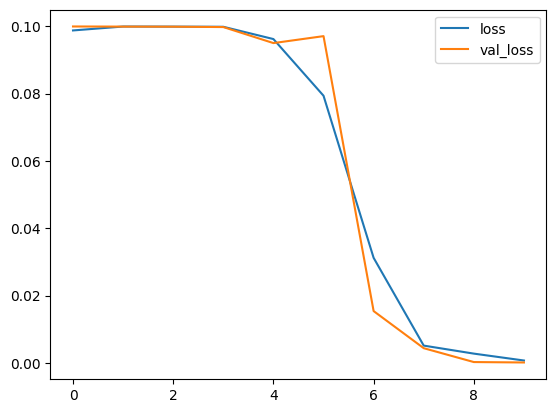

In [ ]:
feature_extractor = train_feature_extractor()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def test_classification(
        file_path_enrol,
        file_path_clf,
        feature_extractor,
        dev_range_enrol = np.arange(30,40, dtype = int),
        pkt_range_enrol = np.arange(0,100, dtype = int),
        dev_range_clf = np.arange(30,40, dtype = int),
        pkt_range_clf = np.arange(100,200, dtype = int)
                        ):
    '''
    test_classification performs a classification task and returns the
    classification accuracy.

    INPUT:
        FILE_PATH_ENROL is the path of enrollment dataset.

        FILE_PATH_CLF is the path of classification dataset.

        FEATURE_EXTRACTOR_NAME is the name of RFF extractor used during
        enrollment and classification.

        DEV_RANGE_ENROL is the label range of LoRa devices during enrollment.

        PKT_RANGE_ENROL is the range of packets from each LoRa device during enrollment.

        DEV_RANGE_CLF is the label range of LoRa devices during classification.

        PKT_RANGE_CLF is the range of packets from each LoRa device during classification.

    RETURN:
        PRED_LABEL is the list of predicted labels.

        TRUE_LABEL is the list true labels.

        ACC is the overall classification accuracy.
    '''
    # Load the enrollment dataset. (IQ samples and labels)
    data_enrol, label_enrol = load_iq_samples(file_path_enrol,
                                              dev_range = dev_range_enrol,
                                              pkt_range = pkt_range_enrol)

    ChannelIndSpectrogramObj = ChannelIndSpectrogram()

    # Convert IQ samples to channel independent spectrograms. (enrollment data)
    data_enrol = ChannelIndSpectrogramObj.channel_ind_spectrogram(data_enrol)

    # # Visualize channel independent spectrogram
    # plt.figure()
    # sns.heatmap(data_enrol[0,:,:,0],xticklabels=[], yticklabels=[], cmap='Blues', cbar=False)
    # plt.gca().invert_yaxis()
    # plt.savefig('channel_ind_spectrogram.pdf')

    # Extract RFFs from channel independent spectrograms.
    feature_enrol = feature_extractor.predict(data_enrol)
    del data_enrol

    # Create a K-NN classifier using the RFFs extracted from the enrollment dataset.
    knnclf=KNeighborsClassifier(n_neighbors=15,metric='euclidean')
    knnclf.fit(feature_enrol, np.ravel(label_enrol))


    # Load the classification dataset. (IQ samples and labels)
    data_clf, true_label = load_iq_samples(file_path_clf,
                                          dev_range = dev_range_clf,
                                          pkt_range = pkt_range_clf)

    # Convert IQ samples to channel independent spectrograms. (classification data)
    data_clf = ChannelIndSpectrogramObj.channel_ind_spectrogram(data_clf)

    # Extract RFFs from channel independent spectrograms.
    feature_clf = feature_extractor.predict(data_clf)
    del data_clf

    # Make prediction using the K-NN classifier.
    pred_label = knnclf.predict(feature_clf)

    # Calculate classification accuracy.
    acc = accuracy_score(true_label, pred_label)
    print('Overall accuracy = %.4f' % acc)

    return pred_label, true_label, acc

In [ ]:
pred_label, true_label, acc = test_classification(file_path_enrol = '/content/dataset_residential.h5',
                                                  file_path_clf = '/content/A.h5',
                                                  feature_extractor = feature_extractor,
                                                  dev_range_enrol = np.arange(30,40, dtype = int))

<ipython-input-3-11967d598270>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_start = int(label[0]) + 1
<ipython-input-3-11967d598270>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_end = int(label[-1]) + 1


Dataset information: Dev 31 to Dev 40, 400 packets per device.
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step
Dataset information: Dev 31 to Dev 40, 200 packets per device.


<ipython-input-3-11967d598270>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_start = int(label[0]) + 1
<ipython-input-3-11967d598270>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_end = int(label[-1]) + 1


32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 380ms/step
Overall accuracy = 0.1500


Text(50.722222222222214, 0.5, 'True label')

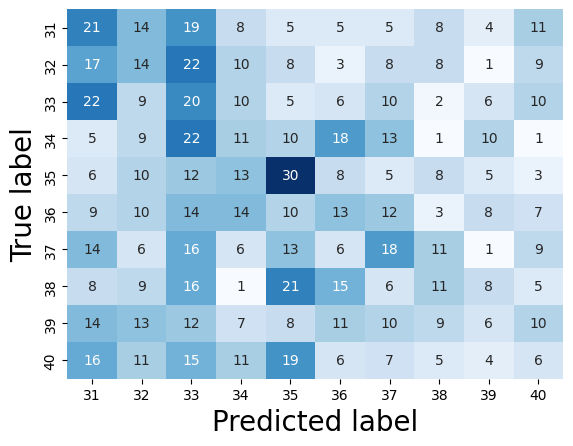

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot the confusion matrix.
conf_mat = confusion_matrix(true_label, pred_label)
classes = np.arange(30,40, dtype = int) + 1

plt.figure()
sns.heatmap(conf_mat, annot=True,
            fmt = 'd', cmap='Blues',
            cbar = False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted label', fontsize = 20)
plt.ylabel('True label', fontsize = 20)